In [64]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import sys
sys.path.append("..") # Adds higher directory to python modules path.
sys.path.append("/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2")
import expansion as ep
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import time
%matplotlib inline
import trap_util as tu
from trap_util import trap
from trap_util import quarter_trap
from trap_util import half_trap
from trap_util_3D import trap_3D
import mysql.connector
import matplotlib.colors as colors
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
# physical parameters
q = -1.60217662e-19 # coulombs
m = 9.10938356e-31 #kg (electron)
#m = 6.6359437706294e-26 #(calcium)
kB = 1.38064852e-23 # J/K
f = 1.5e9 # Electrode frequency, in Hertz

In [2]:
# loading RF E field data
data_RF = np.loadtxt("../etrap_65V_1p5GHz_realsmoothExEy_250nm_30passes_quarter.fld", skiprows = 2)
# manipulating E field data
df_RF = pd.DataFrame(data_RF, columns=['x', 'y', 'z', 'Ex', 'Ey', 'Ez'])
x_max_RF, x_min_RF = df_RF.x.max(), df_RF.x.min()
y_max_RF, y_min_RF = df_RF.y.max(), df_RF.y.min()
# print(x_max, x_min, y_max, y_min)
# print(df.y.nunique())
Nx_RF, Ny_RF = df_RF.x.nunique() - 1, df_RF.y.nunique() - 1 # numbers of intervals that divide each dimension
dx_RF, dy_RF = (x_max_RF-x_min_RF)/Nx_RF, (y_max_RF-y_min_RF)/Ny_RF # interval size
print("x_max = ", x_max_RF*1.0e3, "mm")
print("y_max = ", y_max_RF*1.0e3, "mm")
print("x_min = ", x_min_RF*1.0e3, "mm")
print("y_min = ", y_min_RF*1.0e3, "mm")
print("spatial resolution x: ", dx_RF*1.0e6, "um")
print("spatial resolution y: ", dy_RF*1.0e6, "um")

x_max =  1.0 mm
y_max =  1.5 mm
x_min =  0.0 mm
y_min =  0.0 mm
spatial resolution x:  0.25 um
spatial resolution y:  0.25 um


In [8]:
trap_RF = quarter_trap(df_RF, x_max_RF, x_min_RF, y_max_RF, y_min_RF,\
                      Nx_RF, Ny_RF, dx_RF, dy_RF, f=f)

In [38]:
x_max_DC, x_min_DC = 250.0e-6, -250.0e-6
y_max_DC, y_min_DC = 250.0e-6, -250.0e-6
z_max_DC, z_min_DC = 250.0e-6, -250.0e-6
Nx_DC, Ny_DC, Nz_DC = 100, 100, 100
dx_DC, dy_DC, dz_DC = (x_max_DC-x_min_DC)/Nx_DC, (y_max_DC-y_min_DC)/Ny_DC, (z_max_DC-z_min_DC)/Nz_DC

In [39]:
data_DC = np.loadtxt("etrap_60minch_electrodes_500u_cube_5u_steps_Efield.fld", skiprows = 2)

In [40]:
df_DC = pd.DataFrame(data_DC, columns=['x', 'z', 'y', 'Ex', 'Ez', 'Ey'])
df_DC = df_DC[["x", "y", "z", "Ex", "Ey", "Ez"]]

In [41]:
trap_DC = trap_3D(df_DC, x_max_DC, x_min_DC, y_max_DC, y_min_DC, z_max_DC, z_min_DC, \
                  Nx_DC, Ny_DC, Nz_DC, dx_DC, dy_DC, dz_DC, f=0, q=q, m=m)

In [42]:
def E_field_sim(state, time):
        """This is a function that takes in a 2-element array state and a number time and
        calculates the time derivatives of the state.

        Parameters
        ----------
        state: 1D array of length 2
            state[0] is the current position of the particle and state[1] is 
            the current velocity
        time: 
            the current time
        
        Return
        ----------
        A 1D array with the 0th element being the current velocity and the 1st element being
        the current acceleration
        """
        g0 = state[1]
        x, y, z = state[0]
        RF_ax, RF_ay = trap_RF.acceleration(x, y, time)
        RF_a = np.array([RF_ax, RF_ay, 0.0])
        g1 = RF_a + trap_DC.acceleration(x, y, z, time)
        return np.array([g0, g1])
    
def traj(r, theta_r, phi_r, v, theta_v, phi_v, dt, t_max):
        """Calculates the particle trajectory of a single particle given certain
        initial condition.

        Parameters
        ---------
        rho: float
            initial distance of the particle from the trap center
        phi: float
            angle between the initial position vector and the positive x-axis
        v: float
            initial speed of the particle
        theta: float
            angle between the initial velocity vector and the positive x axis
        dt: float
            time step of the simulation
        t_max: float
            maximum simulation time

        Returns
        ----------
        A list of three lists: t_s, x_traj, y_traj. x_traj[i] and y_traj[i] correspond
        to the (x, y) coordinates of the particle at time t_s[i]
        """
        electron_pos=np.array([r*np.sin(theta_r)*np.cos(phi_r), r*np.sin(theta_r)*np.sin(phi_r), r*np.cos(theta_r)])
        electron_vel = np.array([v*np.sin(theta_v)*np.cos(phi_v), v*np.sin(theta_v)*np.sin(phi_v), v*np.cos(theta_v)])
        state = np.array([electron_pos, electron_vel])
        t = 0.0 # the time variable
        trapped = True
        x_traj, y_traj, z_traj, t_s = [], [], [], []
        # actual simulation
        while t < t_max:
            x, y, z = state[0]
            if not trap_DC.within_boundary(x, y, z):
                trapped = False
                print("Out of bound")
                break
            x_traj.append(x)
            y_traj.append(y)
            z_traj.append(z)
            t_s.append(t)
            state = trap_DC.rk4(state, t, dt, E_field_sim)
            t += dt
        return [t_s, x_traj, y_traj, z_traj]

In [96]:
dt = 1.0e-11
t_max = 1.0e-6
T = 300.0
r = 100.0e-6
theta_r = np.pi/4
phi_r = np.pi/6
v = np.sqrt(3*kB*T/m)
theta_v = np.pi/3
phi_v = 0
ts, xs, ys, zs = traj(r, theta_r, phi_r, v, theta_v, phi_v, dt, t_max)
ts, xs, ys, zs = np.array(ts), np.array(xs), np.array(ys), np.array(zs)

Out of bound


Text(0,0.5,'z (um)')

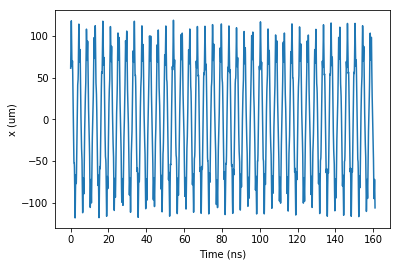

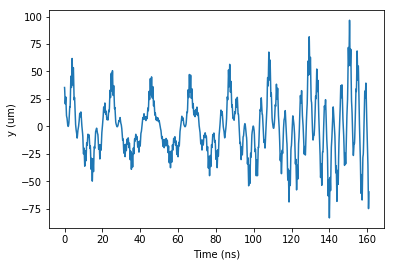

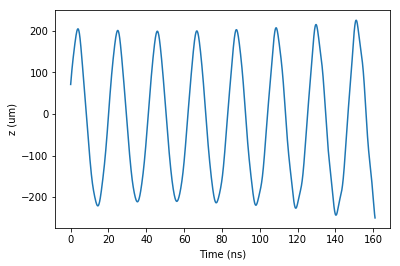

In [97]:
plt.figure()
plt.plot(ts*1.0e9, xs*1.0e6)
plt.xlabel("Time (ns)")
plt.ylabel("x (um)")

plt.figure()
plt.plot(ts*1.0e9, ys*1.0e6)
plt.xlabel("Time (ns)")
plt.ylabel("y (um)")

plt.figure()
plt.plot(ts*1.0e9, zs*1.0e6)
plt.xlabel("Time (ns)")
plt.ylabel("z (um)")

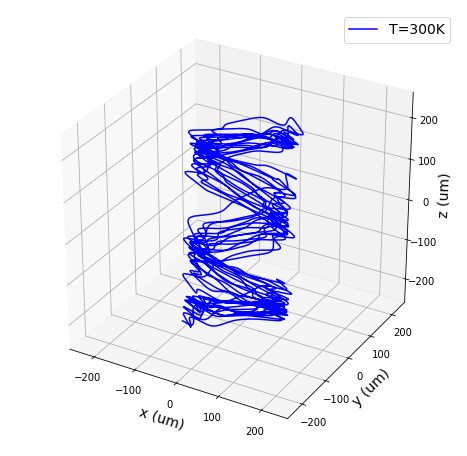

In [98]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot(xs*1.0e6, ys*1.0e6, zs*1.0e6, label='T=300K', color='blue')
ax.set_xlabel("x (um)", fontsize=14)
ax.set_ylabel("y (um)", fontsize=14)
ax.set_zlabel("z (um)",fontsize=14)
ax.set_xlim(-250 , 250)
ax.set_ylim(-250,250)
ax.set_zlim(-250,250)
ax.legend(fontsize=14)

MovieWriter imagemagick unavailable.


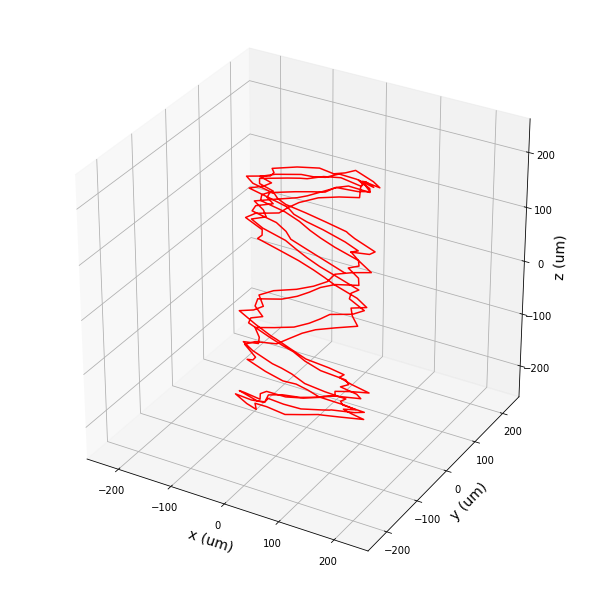

In [91]:
def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        # NOTE: there is no .set_data() for 3 dim data...
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
        line.set_color("red")
    return lines

# Attaching 3D axis to the figure
fig = plt.figure(figsize=(8,8))
ax = p3.Axes3D(fig)

# Lines to plot in 3D
x = np.array([xs[i] for i in range(0, 5001, 20)])
y = np.array([ys[i] for i in range(0, 5001, 20)])
z = np.array([zs[i] for i in range(0, 5001, 20)])
data = np.array([[x*1.0e6, y*1.0e6, z*1.0e6]])

# NOTE: Can't pass empty arrays into 3d version of plot()
lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

ax.set_xlim(-250 , 250)
ax.set_ylim(-250,250)
ax.set_zlim(-250,250)
ax.set_xlabel("x (um)", fontsize=14)
ax.set_ylabel("y (um)", fontsize=14)
ax.set_zlabel("z (um)",fontsize=14)
plt.rcParams['animation.html'] = 'html5'

line_ani = animation.FuncAnimation(fig, update_lines, 250, fargs=(data, lines),
                                   interval=0.01, blit=True, repeat=True)
line_ani.save('traj_anim.gif', writer='imagemagick')

In [76]:
range(1, 10, 2)[4]

9